# Exploratory Data Analysis of Wind

* Please refer to this website to download data https://www.ncdc.noaa.gov/cdo-web/datatools/lcd  Virginia, Norfolk county
* The station ID for Norfolk Naval Station is: 13750
* Time duration: summer months in 2020
* The unit of wind speed is MPH, it should be converted into m/s when use
* The probability of wind speed that is >5m/s was 15.5% in summer 2020
* North-easter and southerly wind were the dominated wind direction in summer 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from windrose import WindroseAxes
import scipy.stats as st
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

In [2]:
# import data
infile = '../data/external/Wind_hourly_2020.csv'
data = pd.read_csv(infile,usecols= [0,1,2,3], parse_dates=['DateTime'], infer_datetime_format=True, sep = ',')
# select the dateTime range
data['DateTime']=pd.to_datetime(data['DateTime'])
data = data[data.DateTime > pd.Timestamp('2020-05-31 23:59:00')]
data = data[data.DateTime < pd.Timestamp('2020-10-06 00:59:00')]
data

,DateTime,WindSpeed,WindDirection,WindGustSpeed
24,2020-06-01 00:59:00,0.0,0.0,NaN
25,2020-06-01 01:59:00,7.0,110.0,NaN
26,2020-06-01 02:59:00,0.0,0.0,NaN
27,2020-06-01 03:59:00,5.0,280.0,NaN
28,2020-06-01 04:59:00,8.0,340.0,NaN
...,...,...,...,...
3043,2020-10-05 19:59:00,0.0,0.0,NaN
3044,2020-10-05 20:59:00,0.0,0.0,NaN
3045,2020-10-05 21:59:00,0.0,0.0,NaN
3046,2020-10-05 22:59:00,0.0,0.0,NaN


In [3]:
# winds peed unit is MPH
WindSpeed =data['WindSpeed']*0.44704 # convert MPH to m/s
WindDir = data['WindDirection']
DateTime = data['DateTime']

### Fill NaN and quiver plot

In [4]:
# fill data gaps
data['WindSpeed'].fillna(method='ffill',inplace=True)
data['WindDirection'].fillna(method='ffill',inplace=True)
# create vector
cos_WindDir = np.deg2rad(data['WindDirection'])
sin_WindDir= np.deg2rad(data['WindDirection'])
U_wind=data['WindSpeed']*0.44704*np.cos(cos_WindDir)
V_wind=data['WindSpeed']*0.44704*np.sin(sin_WindDir)

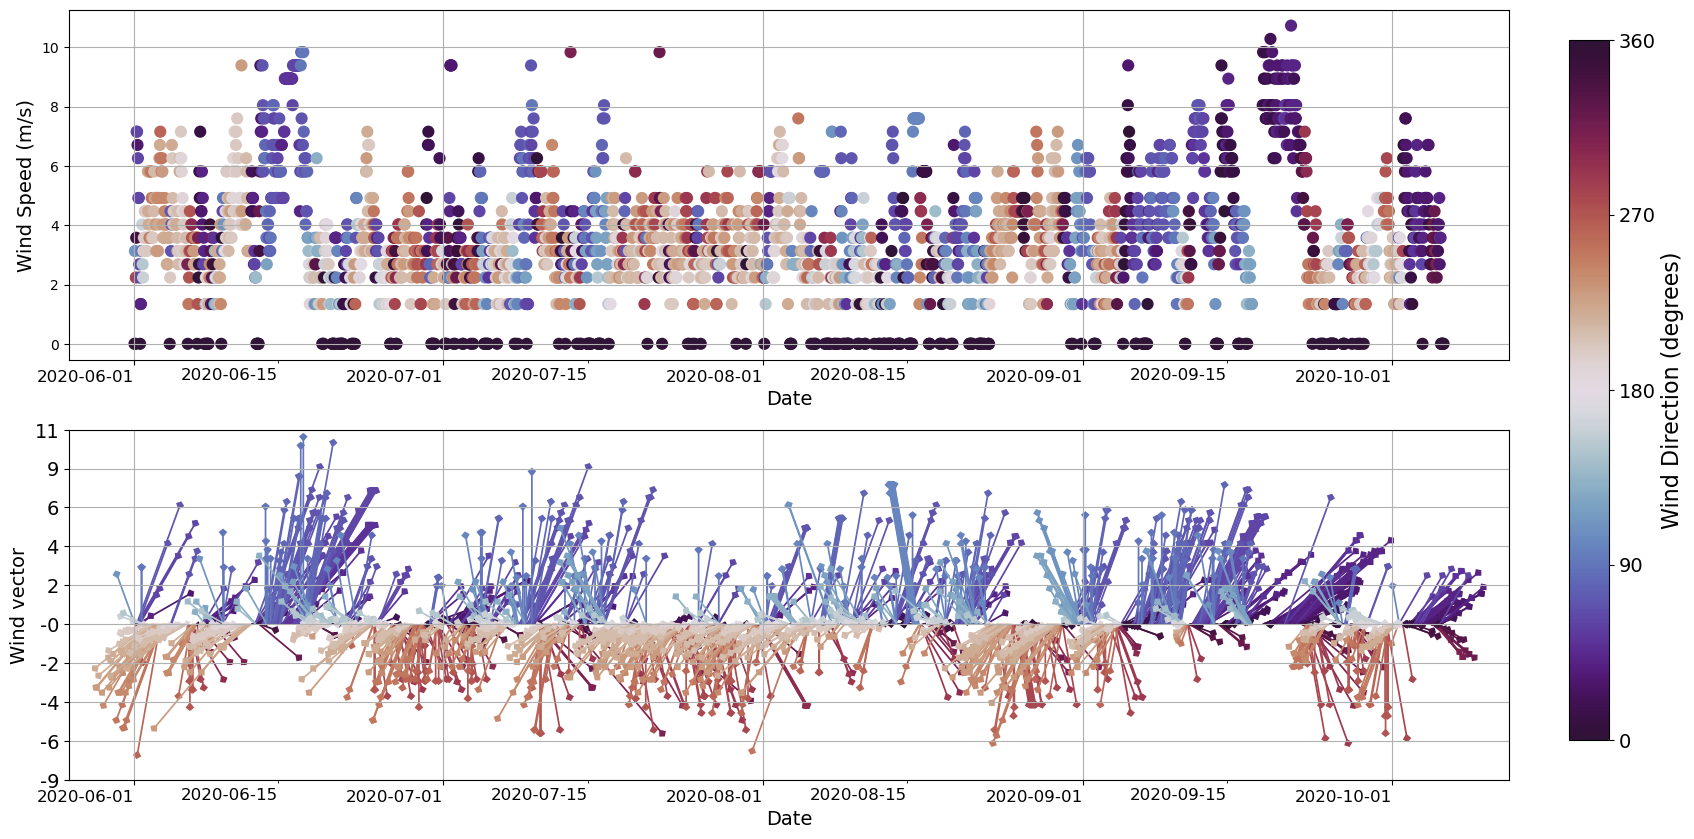

In [5]:
# Create a quiver plot
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Define a colormap based on wind direction
cmap = plt.cm.get_cmap('twilight_shifted', 360)
norm = plt.Normalize(vmin=0, vmax=360)
# Plot the wind direction data in the bottom subplot, using color to indicate direction
scatter=axes[0].scatter(data['DateTime'], data['WindSpeed']*0.44704, c=data['WindDirection'],  s=60, cmap=cmap, norm=norm)
# create a separate axis object for the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
# add the colorbar to the figure
cbar = plt.colorbar(scatter, cbar_ax)
# show only the first 4 ticks on the colorbar
cbar.set_ticks([0, 90, 180, 270,360])
cbar.set_ticklabels(['0', '90', '180', '270','360'])
cbar.set_label('Wind Direction (degrees)',fontsize=16)
cbar.ax.tick_params(labelsize=14)
# adjust the subplot and colorbar positions as needed
fig.subplots_adjust(left=0.15, right=0.87, wspace=0.3)
axes[0].set_ylabel('Wind Speed (m/s)',fontsize=14)
axes[0].set_xlabel('Date',fontsize=14)
date_fmt = mdates.DateFormatter('%Y-%m-%d')
axes[0].xaxis.set_major_formatter(date_fmt)
axes[0].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
month_locator = mdates.MonthLocator()
day_locator = mdates.DayLocator(bymonthday=[1, 15])
axes[0].xaxis.set_major_locator(month_locator)
axes[0].xaxis.set_minor_locator(day_locator)
#axes[0].set_xlim(min(Date_Time),max(Date_Time))
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[0].get_xticklabels(which='both'), rotation=0, ha='right', fontsize=12)
axes[0].grid(True)
# second subplot
y = np.zeros(len(data['DateTime']))
# Convert wind directions to colors
norm = mcolors.Normalize(vmin=0, vmax=360)
colors = plt.cm.twilight_shifted(norm(data['WindDirection']))
q=axes[1].quiver(data['DateTime'], y, U_wind, V_wind, color= colors, scale=10, scale_units='xy', width=0.0012, headwidth=5, headlength=2)
# Set y-axis tick labels to correspond to true wind speed
y_ticks = np.arange(-(np.ceil(np.max(y))+0.8), np.ceil(np.max(y))+1.1, 0.2)
y_tick_labels = ['{:.0f}'.format(WindSpeed.max() * t) for t in y_ticks]
axes[1].set_yticks(y_ticks,fontsize=14)
axes[1].set_yticklabels(y_tick_labels,fontsize=14)
axes[1].set_ylabel('Wind vector',fontsize=14)
axes[1].set_xlabel('Date',fontsize=14)

axes[1].xaxis.set_major_formatter(date_fmt)
axes[1].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
axes[1].xaxis.set_major_locator(month_locator)
axes[1].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[1].get_xticklabels(which='both'), rotation=0, ha='right', fontsize=12)
axes[1].grid(True)
plt.show()



### Excluding NaN from the dataset and replot the wind quiver

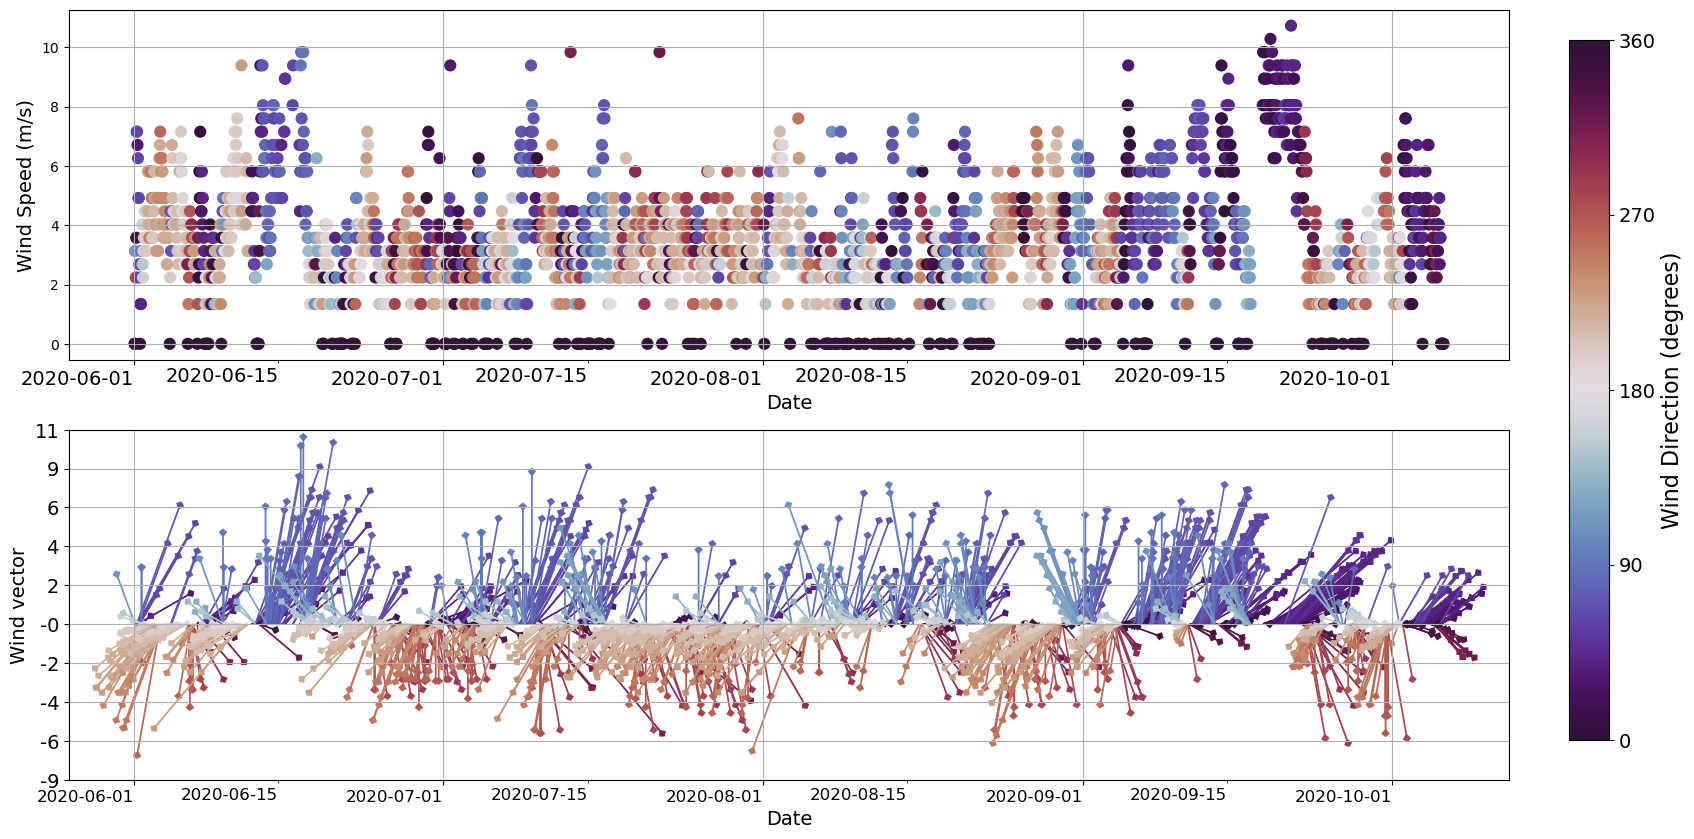

In [6]:
# using index to exclude NaN in the dataset
idx = ~np.isnan(WindSpeed) & ~np.isnan(WindDir)
speeds=WindSpeed[idx]
Dir = WindDir[idx]
Date_Time = DateTime[idx]
# create vector
cos_WindDir = np.deg2rad(Dir)
sin_WindDir= np.deg2rad(Dir)
U_wind=speeds*np.cos(cos_WindDir)
V_wind=speeds*np.sin(sin_WindDir)

# Create a quiver plot
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Define a colormap based on wind direction
cmap = plt.cm.get_cmap('twilight_shifted', 360)
norm = plt.Normalize(vmin=0, vmax=360)
# Plot the wind direction data in the bottom subplot, using color to indicate direction
scatter=axes[0].scatter(Date_Time, speeds, c=Dir,  s=60, cmap=cmap, norm=norm)
# create a separate axis object for the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
# add the colorbar to the figure
cbar = plt.colorbar(scatter, cbar_ax)
# show only the first 4 ticks on the colorbar
cbar.set_ticks([0, 90, 180, 270,360])
cbar.set_ticklabels(['0', '90', '180', '270','360'])
cbar.set_label('Wind Direction (degrees)',fontsize=16)
cbar.ax.tick_params(labelsize=14)
# adjust the subplot and colorbar positions as needed
fig.subplots_adjust(left=0.15, right=0.87, wspace=0.3)
axes[0].set_ylabel('Wind Speed (m/s)',fontsize=14)
axes[0].set_xlabel('Date',fontsize=14)
date_fmt = mdates.DateFormatter('%Y-%m-%d')
axes[0].xaxis.set_major_formatter(date_fmt)
axes[0].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
month_locator = mdates.MonthLocator()
day_locator = mdates.DayLocator(bymonthday=[1, 15])
axes[0].xaxis.set_major_locator(month_locator)
axes[0].xaxis.set_minor_locator(day_locator)
#axes[0].set_xlim(min(Date_Time),max(Date_Time))
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[0].get_xticklabels(which='both'), rotation=0, ha='right', fontsize=14)
axes[0].grid(True)


# second subplot
y = np.zeros(len(Date_Time))
# Convert wind directions to colors
norm = mcolors.Normalize(vmin=0, vmax=360)
colors = plt.cm.twilight_shifted(norm(Dir))
q=axes[1].quiver(Date_Time, y, U_wind, V_wind, color= colors, scale=10, scale_units='xy', width=0.0012, headwidth=5, headlength=2)
# Set y-axis tick labels to correspond to true wind speed
y_ticks = np.arange(-(np.ceil(np.max(y))+0.8), np.ceil(np.max(y))+1.1, 0.2)
y_tick_labels = ['{:.0f}'.format(speeds.max() * t) for t in y_ticks]
axes[1].set_yticks(y_ticks,fontsize=14)
axes[1].set_yticklabels(y_tick_labels,fontsize=14)
axes[1].set_ylabel('Wind vector',fontsize=14)
axes[1].set_xlabel('Date',fontsize=14)

axes[1].xaxis.set_major_formatter(date_fmt)
axes[1].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
axes[1].xaxis.set_major_locator(month_locator)
axes[1].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[1].get_xticklabels(which='both'), rotation=0, ha='right', fontsize=12)
axes[1].grid(True)
plt.show()



### Plot WindRose

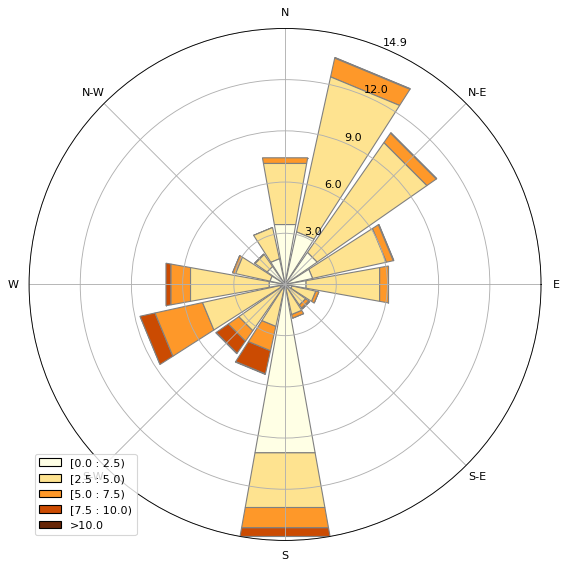

In [7]:
# Create a new WindroseAxes object with north direction as 0
ax = WindroseAxes.from_ax()

ax.bar(Dir,speeds,normed=True, opening=0.9, nsector = 16,blowto='False',edgecolor='grey', bins=np.arange(0,12.5,2.5),cmap=cm.YlOrBr)

# Add a legend to the plot
ax.legend()

plt.show()

* Windrose documentation link https://buildmedia.readthedocs.org/media/pdf/windrose/latest/windrose.pdf

### Plot the frequency of the wind direction

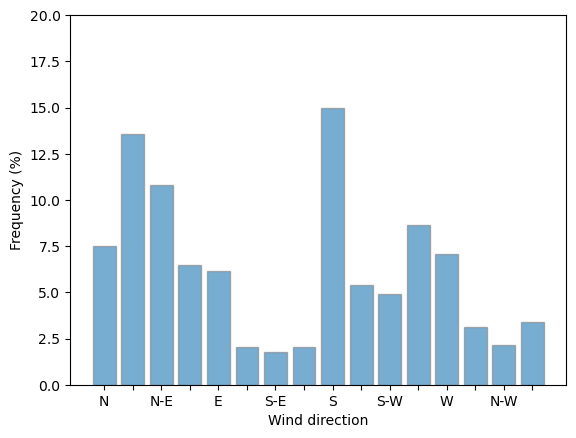

In [8]:
# So, to know the frequency of each wind direction, for all wind speeds:
table = ax._info['table']
wd_freq = np.sum(table, axis = 0)
# and to have a graphical representation of this result
plt.bar(np.arange(16), wd_freq, align='center',alpha=0.6,edgecolor='grey')
xlabels = ('N','','N-E','','E','','S-E','','S','','S-W','','W','','N-W','')
xticks=np.arange(16)
plt.ylim(0, 20)
plt.xticks(xticks,xlabels)
plt.xlabel('Wind direction')
plt.ylabel('Frequency (%)')
plt.show()

### Plot the histogram of wind speed

The probability of wind speed that is greater than 5 m/s is:  15.5%


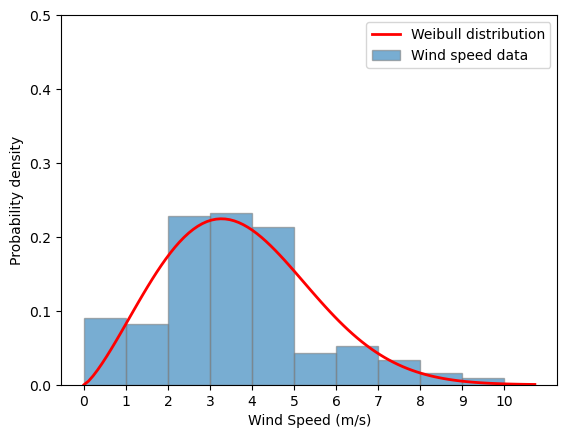

In [9]:
# Set the desired bin width
bin_width = 1
# Compute the sequence of bin edges based on the bin width
bin_edges = range(int(min(speeds)), int(max(speeds)) + bin_width, bin_width)
# Generate a histogram of the wind speed data
h=plt.hist(speeds, bins =bin_edges, density=True, alpha=0.6, edgecolor='grey')
plt.xticks(np.arange(int(min(speeds)), int(max(speeds)+1), 1))
# calculate the probability of wind speed that is greater than 5 m/s
prob=h[0]

sum_prob= np.sum(prob[5:])*100
print('The probability of wind speed that is greater than 5 m/s is: ', f"{sum_prob:.1f}%" )

# Fit a Weibull distribution to the wind speed  data
params = st.weibull_min.fit(speeds,floc=0.000000001)
# if you believe that the minimum wind speed is zero (i.e., the wind speed cannot be negative), you can fix floc to 0.
#shape = params[0]
#scale = params[2]
#loc  = params[1]
x = np.linspace(0, np.max(speeds), 100)
y = st.weibull_min.pdf(x, *params)
# Generate a plot of the Weibull distribution
plt.plot(x, y, 'r-', linewidth=2)

plt.ylim(0, 0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability density')
plt.legend(['Weibull distribution','Wind speed data'])
# Show the plot
plt.show()